# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [00:34<00:00, 2549.13it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


In [1]:
type(preprocessed_reviews)

NameError: name 'preprocessed_reviews' is not defined

## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

E:\anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('fantastic', 0.8528234958648682), ('awesome', 0.8469642996788025), ('good', 0.8387990593910217), ('excellent', 0.8244222402572632), ('terrific', 0.8063042163848877), ('wonderful', 0.7800127267837524), ('perfect', 0.7517625093460083), ('nice', 0.739225447177887), ('amazing', 0.7347272634506226), ('decent', 0.6865548491477966)]
[('greatest', 0.7823413610458374), ('best', 0.7144616842269897), ('tastiest', 0.6958818435668945), ('nastiest', 0.6628590822219849), ('nicest', 0.6548948287963867), ('disgusting', 0.6292867064476013), ('horrible', 0.6242440938949585), ('coolest', 0.6185537576675415), ('cry', 0.6021839380264282), ('awful', 0.6009469032287598)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [03:54<00:00, 373.92it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [38:41<00:00, 37.80it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [35]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from scipy import *
from scipy.sparse import *

In [36]:
y=final["Score"]

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, y, test_size=0.33)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.33)


### [5.1.1] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [38]:
# Please write all the code with proper documentation# Bag of Words

count_vect = CountVectorizer(dtype='float')
bow_x_train = count_vect.fit_transform(x_train)
bow_x_test = count_vect.transform(x_test)


In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

lam = [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000, 10000]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf, param_grid ,cv = 5,n_jobs = 3, scoring = 'roc_auc' )
grid.fit(bow_x_train, y_train)


train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(log(lam), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,train_auc - train_auc_std,train_auc + train_auc_std, alpha = 0.2,color='darkblue')

plt.plot(log(lam) , cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha = 0.2,color='darkorange')
plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-2-38246e65b389>, line 7)

In [162]:
#Using L2 Regularizer
clf = LogisticRegression(C = 0.0031, class_weight = 'balanced' )

clf.fit(bow_x_train,y_train)

pred = clf.predict(bow_x_test)
pred1 = clf.predict(bow_x_train)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.313816%

precision=96.295611%

recall=85.775489%

F1-Score=90.731622%


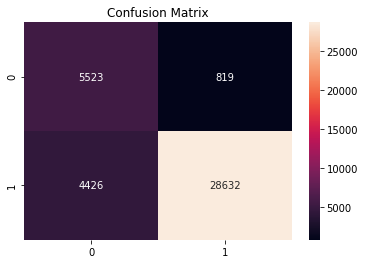

In [46]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

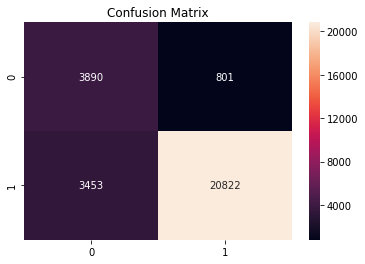

In [47]:
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

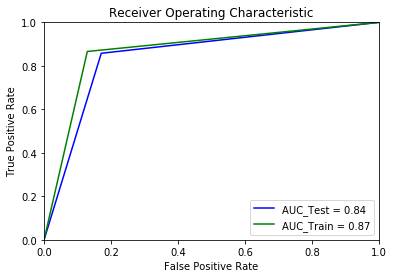

In [163]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [48]:
weight = clf.coef_
a = np.count_nonzero(weight)
b = weight.size

print("\n\nSparsity on weight vector obtained using L1 regularization is : ",((b-a)/b)*100)



Sparsity on weight vector obtained using L1 regularization is :  0.0


### [5.1.2] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [50]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
clf = LogisticRegression(C = 0.0031 , penalty='l1', class_weight = 'balanced')

clf.fit(bow_x_train,y_train)

pred = clf.predict(bow_x_test)
pred1 = clf.predict(bow_x_train)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=70.696679%

precision=94.518076%

recall=69.038105%

F1-Score=79.793363%


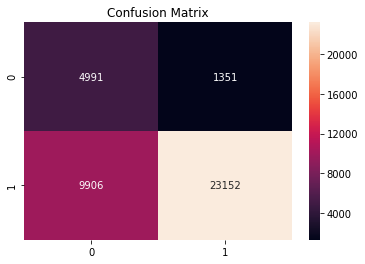

In [51]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

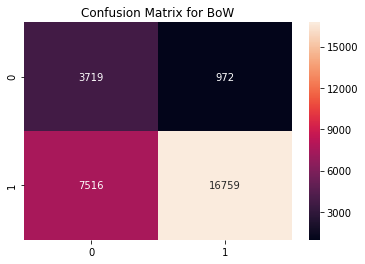

In [52]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [148]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

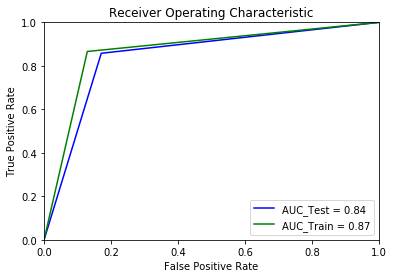

In [159]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [59]:
# Please write all the code with proper documentation0

LR = LogisticRegression(penalty='l2',C=1, class_weight = 'balanced')
LR.fit(bow_x_train,y_train)
weight1 = LR.coef_ # weight vector

# Getting new data set by addind a small noise
new_train = bow_x_train.astype(float)
new_train.data += np.random.uniform(-0.0001,0.0001,1 )

# Fitting the model again on new data
LR = LogisticRegression(penalty='l2',C=1)
LR.fit(new_train,y_train)
weight2 = LR.coef_

# Adding small esilon to weight vector to avoid division by 0
weight1 += 10**-6
weight2 += 10**-6

percentage_change_vector = abs( (weight1-weight2) / (weight1) )*100

0 th percentile :  0.0013670668362249416
10 th percentile :  5.346065345494294
20 th percentile :  10.161875736118368
30 th percentile :  14.873300368964772
40 th percentile :  19.63168811518696
50 th percentile :  24.970740538928442
60 th percentile :  32.13845635792365
70 th percentile :  43.606467195711005
80 th percentile :  73.99382688308438
90 th percentile :  162.18699355349406
100 th percentile :  602492.1944282169


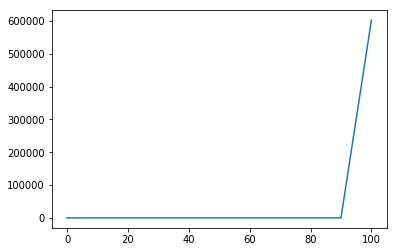

In [60]:
t = range(0,101,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

90 th percentile :  162.18699355349406
91 th percentile :  183.52465494004616
92 th percentile :  205.97920481141392
93 th percentile :  232.47628397467292
94 th percentile :  265.8543553231493
95 th percentile :  306.1009860176963
96 th percentile :  376.5054663214065
97 th percentile :  482.66833347281903
98 th percentile :  722.1457875316548
99 th percentile :  1390.8184684828354
100 th percentile :  602492.1944282169


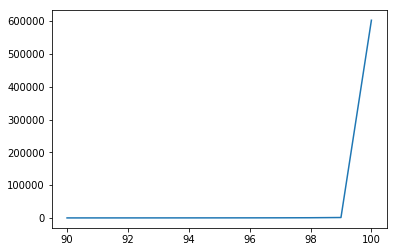

In [61]:
t = range(90,101,1)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

99.0 th percentile :  1390.8184684828354
99.11111111111111 th percentile :  1506.838894300598
99.22222222222223 th percentile :  1798.5864644882906
99.33333333333333 th percentile :  2250.5496281575834
99.44444444444444 th percentile :  2634.10738876698
99.55555555555556 th percentile :  3425.9974192004693
99.66666666666667 th percentile :  4628.1079253921625
99.77777777777777 th percentile :  6343.860040723577
99.88888888888889 th percentile :  13041.839044575197
100.0 th percentile :  602492.1944282169


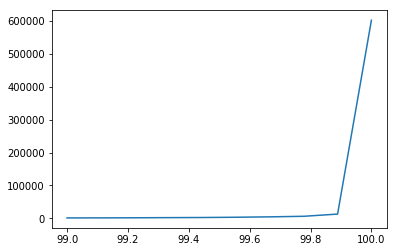

In [62]:
t = np.linspace(99,100,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

In [63]:
diff = (abs(weight1 - weight2)/weight1) * 100
q = diff[np.where(diff > 30)].size
print("Percentage of features which did not change by more than 30% is :",(weight1.size - q)/weight1.size*100)
vect = count_vect.fit_transform(x_train)
feat_log = diff
fea_names1 = count_vect.get_feature_names()
p = pd.DataFrame(feat_log.T, columns=['+ve'])
p['feature'] = fea_names1
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  multicollinear features are", np.array(q['feature'][:10]))
                  


Percentage of features which did not change by more than 30% is : 70.76328759824165
Top 10  multicollinear features are ['lakewood' 'anonymous' 'smp' 'bpp' 'blunder' 'indecipherable' 'mumbo'
 'mutter' 'bacterias' 'brighly']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [64]:
# Please write all the code with proper documentation
LR = LogisticRegression(penalty='l2',C=1, class_weight = 'balanced')
LR.fit(bow_x_train,y_train)
feat_log = LR.coef_
p = count_vect.fit_transform(x_train)
p = pd.DataFrame(feat_log.T, columns=['+ve'])
fea_names = count_vect.get_feature_names()
np.transpose(feat_log)




array([[3.63357175e-02],
       [5.73111032e-01],
       [1.35229969e-02],
       ...,
       [3.57116064e-04],
       [8.00815536e-04],
       [1.77133298e-01]])

In [65]:
p['feature'] = fea_names
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  important features of positive class", np.array(q['feature'][:10]))

Top 10  important features of positive class ['worried' 'amazing' 'delicious' 'resist' 'favorites' 'beat' 'fabulous'
 'hooked' 'excellent' 'complaint']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [66]:
# Please write all the code with proper documentation
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of negative class ['disappointment' 'awful' 'cancelled' 'rip' 'sounded' 'terrible'
 'multigrain' 'flavorless' 'worst' 'disappointing']


In [67]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,0.1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,0.1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer |  C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 0.1 |    85.31    |     14.69     |     96.3     |   85.78   |    90.73    |
| Grid |      L1     | 0.1 |     70.7    |      29.3     |    94.52     |   69.04   |    79.79    |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [68]:
tf_idf = TfidfVectorizer ()
tf_x_train = tf_idf.fit_transform(x_train)
tf_x_test = tf_idf.transform(x_test)

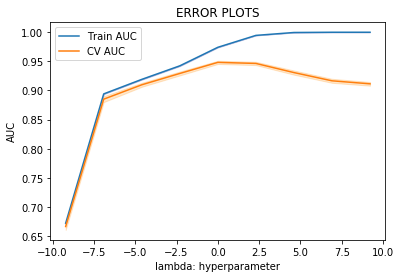

In [70]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

lam = [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000, 10000]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3, scoring = 'roc_auc')
grid.fit(tf_x_train, y_train)


train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(log(lam), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,train_auc - train_auc_std,train_auc + train_auc_std, alpha = 0.2,color='darkblue')

plt.plot(log(lam) , cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha = 0.2,color='darkorange')
plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [169]:
clf = LogisticRegression(C = 1 , penalty='l1', class_weight = 'balanced')

clf.fit(tf_x_train,y_train)

pred = clf.predict(tf_x_test)
pred1 = clf.predict(tf_x_train)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=87.837465%

precision=96.967228%

recall=88.247168%

F1-Score=92.401924%


In [73]:
weight = clf.coef_
a = np.count_nonzero(weight)
b = weight.size

print("\n\nSparsity on weight vector obtained using L1 regularization is : ",((b-a)/b)*100)



Sparsity on weight vector obtained using L1 regularization is :  95.86252830691355


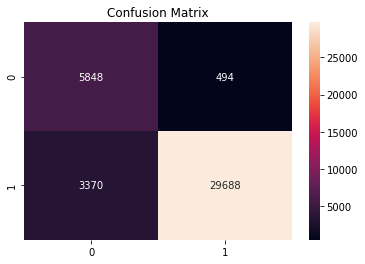

In [74]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

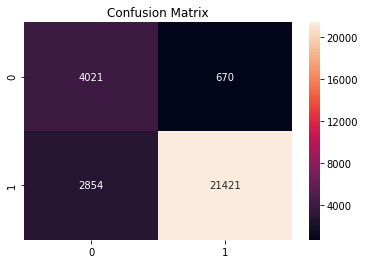

In [75]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

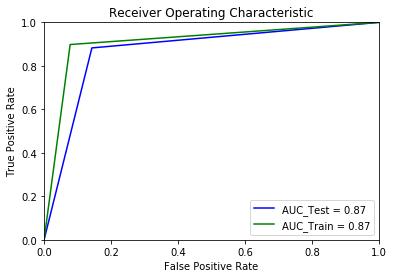

In [170]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [166]:
clf = LogisticRegression(C = 1, class_weight = 'balanced')

clf.fit(tf_x_train,y_train)

pred = clf.predict(tf_x_test)
pred1 = clf.predict(tf_x_train)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=88.835186%

precision=96.822288%

recall=89.618950%

F1-Score=93.081465%


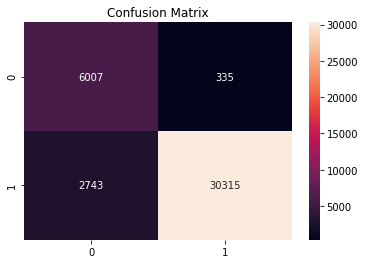

In [91]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

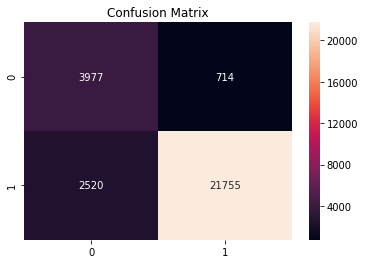

In [92]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()


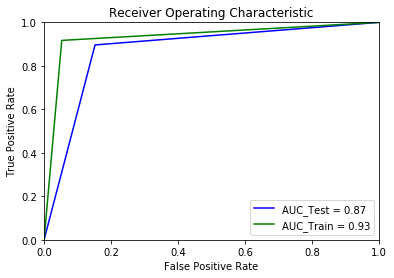

In [167]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [79]:
# Please write all the code with proper documentation# Please write all the code with proper documentation
LR = LogisticRegression(penalty='l2',C=1, class_weight = 'balanced')
LR.fit(tf_x_train,y_train)
feat_log = LR.coef_
p = tf_idf.fit_transform(x_train)
p = pd.DataFrame(feat_log.T, columns=['+ve'])
fea_names = count_vect.get_feature_names()




In [80]:
p['feature'] = fea_names
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  important features of positive class", np.array(q['feature'][:10]))

Top 10  important features of positive class ['great' 'delicious' 'best' 'perfect' 'good' 'excellent' 'wonderful'
 'love' 'loves' 'amazing']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [81]:
# Please write all the code with proper documentation
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of negative class ['disappointment' 'weak' 'horrible' 'awful' 'unfortunately' 'terrible'
 'disappointed' 'disappointing' 'worst' 'not']


In [82]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,0.1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,0.1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer |  C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 0.1 |    91.06    |      8.94     |    91.69     |   98.23   |    94.85    |
| Grid |      L1     | 0.1 |    87.83    |     12.17     |    96.97     |   88.24   |     92.4    |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [83]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())


In [84]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])


(39400, 50)
[ 0.17047252 -0.19692592  0.47601529  0.18629441  0.60859595 -0.69000004
 -0.09085988  0.30906022  0.02259959  0.48487665 -0.52054276  0.6316896
 -0.11635837  0.09947754 -0.57085983 -0.50875143 -0.10888901  0.38281017
  0.40866732 -1.12032016  0.97557838  0.54995185 -0.06037667 -0.05337324
  0.91054769  0.54078094 -0.51447797  0.9230487  -0.4471414   0.29863161
 -0.10292384  1.24850489  0.04771023  0.40869822 -0.35363624  0.301336
  0.11769233 -0.33217671 -0.29455029 -0.3985552   0.06381618  0.26828479
 -0.19401676  0.5410094   0.76484496  0.61543387 -0.07144554  1.29153048
  0.34569334  0.14332547]


In [85]:
i=0
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


(19407, 50)
[ 0.04929585 -0.05265421  0.84555987  0.24927285  0.28484297 -0.84631958
  0.65184915  0.09885945  0.54247457 -0.19222113 -0.2325018   0.76553029
 -0.05580004  0.70563784 -0.8177946  -0.0771226   0.06969617  0.29524436
 -1.01504674 -0.22557137  1.1778318  -0.09820244 -0.40735555 -0.46877841
  0.07843511  0.12287764  0.12651044  0.47501964 -0.51461376  0.43860746
 -0.03863651  0.66516173  0.38342064 -1.2602381   0.27901326  0.21710662
 -0.86448892  0.19803514  0.2273383   0.63955129 -0.60717643 -0.42217821
  0.05013777  0.43904793  0.12981374 -0.07865628 -0.30835659  1.15922581
 -0.03252959 -0.45915694]


In [86]:
i=0
list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [87]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])


(28966, 50)
[-0.30741825 -0.71482162 -0.72901566  0.61490951 -0.18981802 -0.34975914
  0.29898794  0.57403693  0.21726793 -0.07392215 -0.51788692  0.87502302
 -0.03207725  0.27550086 -1.14736202 -0.58391411 -0.80378947 -0.26173521
  0.11070828 -0.74913934  1.10632499 -0.50408179  0.14094426  0.61334647
 -0.08571911  0.02949074  0.68619159 -0.30614666 -1.39805688  0.39623645
  0.11289973  0.33938933  0.23510336  0.1778904  -0.67951091  0.62763757
 -0.37229663 -0.58304334  0.23731652  0.56102772 -0.72269587 -0.17174142
 -0.52313236  0.63073843  0.48309666  0.51411779  0.19413818  0.7672284
  0.31962135  0.45628447]


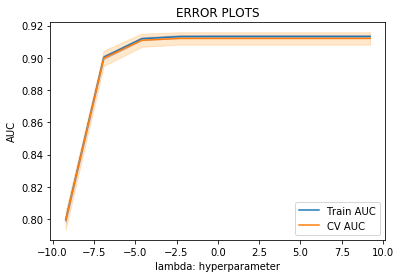

In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

lam =[0.0001,0.001,0.01,0.1, 1, 10, 100, 1000, 10000]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3, scoring = 'roc_auc')
grid.fit(sent_vectors_train, y_train)


train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(log(lam), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,train_auc - train_auc_std,train_auc + train_auc_std, alpha = 0.2,color='darkblue')

plt.plot(log(lam) , cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha = 0.2,color='darkorange')
plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [171]:
clf = LogisticRegression(C = 1 , penalty='l1')

clf.fit(sent_vectors_train,y_train)

pred = clf.predict(sent_vectors_test)
pred1 = clf.predict(sent_vectors_train)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=88.862805%

precision=90.949768%

recall=96.292482%

F1-Score=93.544902%


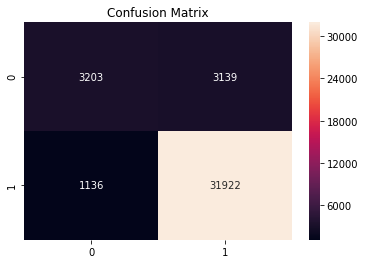

In [129]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

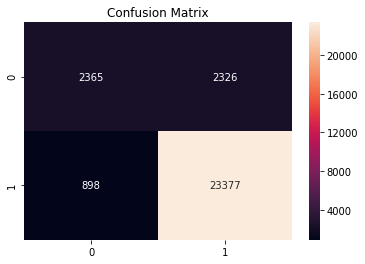

In [130]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

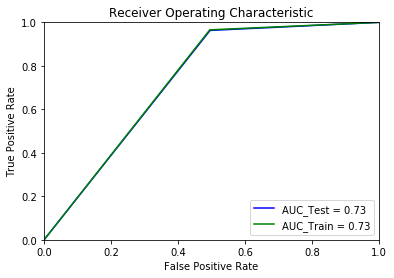

In [172]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [173]:
# Please write all the code with proper documentation
clf = LogisticRegression(C = 1, class_weight = 'balanced' )

clf.fit(sent_vectors_train,y_train)

pred = clf.predict(sent_vectors_test)
pred1 = clf.predict(sent_vectors_train)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=82.061728%

precision=96.423184%

recall=81.623069%

F1-Score=88.407996%


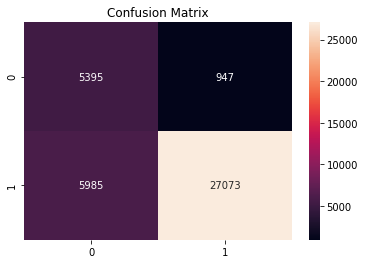

In [132]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

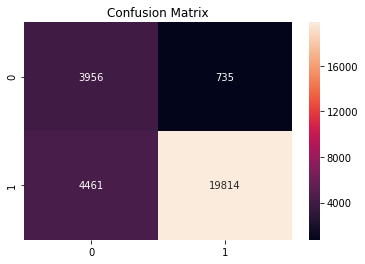

In [133]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

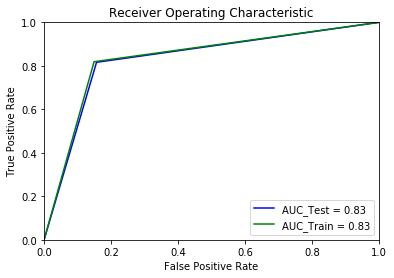

In [174]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [134]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,0.1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,0.1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer |  C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 0.1 |    88.84    |     11.16     |    96.82     |   89.62   |    93.08    |
| Grid |      L1     | 0.1 |    82.06    |     17.94     |    96.42     |   81.62   |    88.41    |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [106]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

In [107]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum!=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [108]:
i=0
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum!=0:
        sent_vec /= weight_sum
    sent_vectors_cv.append(sent_vec)
    row += 1  

In [109]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum!=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

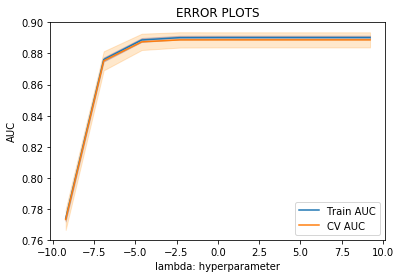

In [110]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

lam = [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000, 10000]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3, scoring = 'roc_auc')
grid.fit(tfidf_sent_vectors, y_train)


train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score'] 
cv_auc_std= grid.cv_results_['std_test_score']

plt.plot(log(lam), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,train_auc - train_auc_std,train_auc + train_auc_std, alpha = 0.2,color='darkblue')

plt.plot(log(lam) , cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log(lam) ,cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha = 0.2,color='darkorange')
plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [175]:
# Please write all the code with proper documentationclf = LogisticRegression(C = 0.1 , penalty='l1')
clf = LogisticRegression(C = 1, penalty='l1' )
clf.fit(tfidf_sent_vectors,y_train)

pred = clf.predict(tfidf_sent_vectors_test)
pred1 = clf.predict(tfidf_sent_vectors)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=87.519851%

precision=89.514957%

recall=96.399588%

F1-Score=92.829799%


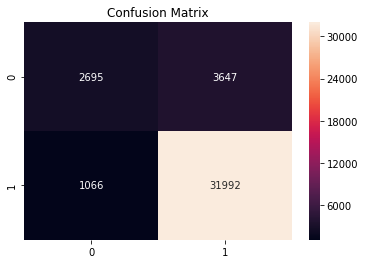

In [136]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

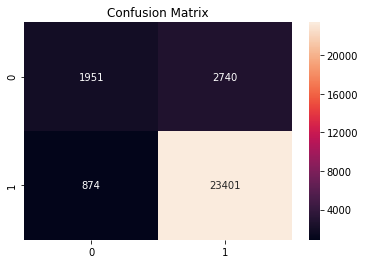

In [137]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

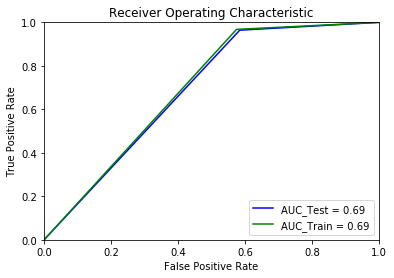

In [176]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [177]:
# Please write all the code with proper documentation
clf = LogisticRegression(C = 1)

clf.fit(tfidf_sent_vectors,y_train)

pred = clf.predict(tfidf_sent_vectors_test)
pred1 = clf.predict(tfidf_sent_vectors)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=87.554374%

precision=89.531059%

recall=96.424305%

F1-Score=92.849918%


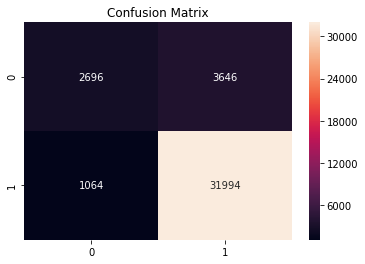

In [139]:
import seaborn as sns
cm = confusion_matrix(y_train,pred1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

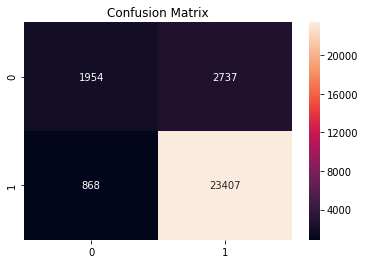

In [140]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

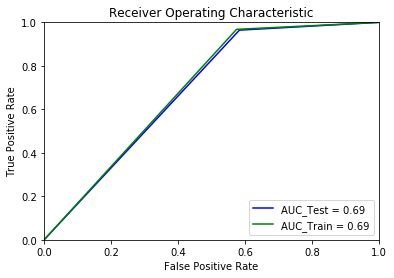

In [178]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pred1)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_Train = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [141]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,0.1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,0.1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer |  C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 0.1 |    88.84    |     11.16     |    96.82     |   89.62   |    93.08    |
| Grid |      L1     | 0.1 |    87.55    |     12.45     |    89.53     |   96.42   |    92.85    |
+------+-------------+-----+-------------+---------------+--------------+-----------+-------------+


# [6] Conclusions

1) Since we found that 70.76% of the data did not show differences greater than 30% when we add pertubation , we can say that the features are not collinear.
2) TFIDF featurization with a L2 regulatization gave the best accuracy of 91.06%.
3) 100000 points were considered for this mode.
4) Pretty tables and confusion matrices have been plotted for all models for easy interpretability of data.
5) All models which have been considered have given a test accuracy of over 75%.